In [ ]:
# # uncomment and run to install any required modules from requirements.txt
# import sys
# !{sys.executable} -m pip install -r requirements.txt

# NP-FAERS model train and test
This notebook uses the natural products annotation corpus to train and test a Siamese recurrent network that maps strings in FAERS to standardized natural product names.

# Load data

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
import re

## Preprocess Data

1. Remove digits and punctuation
2. Upper case
3. Mutating strings (not in this version)

In [2]:
#if starting from preprocess, load the drugs directly
df = pd.read_csv('data/NP_FAERS_mapped_indications_join_on_drugname_20220218.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8274 entries, 0 to 8273
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   FAERS_drug_match  8274 non-null   object
 1   lookup_value      8274 non-null   object
 2   indi_pt           4930 non-null   object
dtypes: object(3)
memory usage: 194.0+ KB


In [3]:
#make all casing upper
df['FAERS_drug_match'] = df['FAERS_drug_match'].str.upper()
df['lookup_value'] = df['lookup_value'].str.upper()
df['indi_pt'] = df['indi_pt'].str.upper()

In [4]:
df.head()

,FAERS_drug_match,lookup_value,indi_pt
0,"ADRENAL HEALTH (BRAND) = (SIBERIAN RHODIOLA, R...",ASHWAGANDA,NaN
1,ASHWAGANDHA,ASHWAGANDA,PRODUCT USED FOR UNKNOWN INDICATION
2,ASHWAGANDHA,ASHWAGANDA,ROUTINE HEALTH MAINTENANCE
3,ASHWAGANDHA,ASHWAGANDA,STRESS
4,ASHWAGANDHA,ASHWAGANDA,ARTHROPATHY


In [5]:
df.lookup_value.unique().shape

(126,)

# RNN character-based encoder - Siamese Network

## Experiments
1. Unique natural product strings 
2. Unique natural product string - negative pairs random also
3. Unique natural product strings with indications
4. Mutations?

### Set up positive pairs and negative pairs  
  - positive pairs coded 'yes' in annotation corpus
  - negative pairs coded 'no' in annotation corpus and random from train data

In [6]:
import tensorflow as tf
import string
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

## Functions to process data

In [7]:
# how i add noise 
# string w 
# proportion of noise added 
# uniform random from [0,1]
# if <1/3 edit one position with new random character, else if <2/3 delete one position, else add one random character 
def add_noise(w, percent):
  ''' edit, del, add'''
  positions = random.choices(range(len(w)), k=int(percent*len(w)))
  for p in positions:
    r = random.random()
    if r <= 0.3333: # edit
      w = w[:p] + random.choice(string.ascii_uppercase) + w[p+1:]
    elif r<= 0.6667: # delete
      w = w[:p] + w[p+1:]
    elif r<=1: # add
      w = w[:p] + random.choice(string.ascii_uppercase) + w[p:]
  return w

def clean(text):
    #remove all non-ascii, special characters and keep alphabets and space only. Can also use isalpha()
    #convert to uppercase
    #remove extra spaces
    regex = re.compile('[^a-zA-Z ]')
    r = regex.sub('', text)
    result = re.sub(' +', ' ', r)
    result = result.strip()
    return result.upper()

In [8]:
def clean_dataset(data):
  x = []
  y = []
  for i in range(data.shape[0]):
    w = clean(data.FAERS_drug_match_indi.iloc[i])
    v = clean(data.lookup_value.iloc[i])
    x.append(w)
    y.append(v)
  return x,y

def encode_dataset(x,y):
  encode_dict = {l:i+1 for i,l in enumerate(string.ascii_uppercase + " ")}
  Xtrain = [[encode_dict[m] for m in n] for n in x]
  Ytrain = [[encode_dict[m] for m in n] for n in y]
  return Xtrain, Ytrain

def clean_encode_padding(q, maxlen):
  q = clean(q)
  encode_dict = {l:i+1 for i,l in enumerate(string.ascii_uppercase + " ")}
  return tf.keras.preprocessing.sequence.pad_sequences(
    [encode_dict[m] for m in q] , padding="post", maxlen=maxlen)

def padding_dataset(X,Y,maxlen):
  padded_y = tf.keras.preprocessing.sequence.pad_sequences(
    Y, padding="post", maxlen=maxlen)
  padded_x = tf.keras.preprocessing.sequence.pad_sequences(
      X, padding="post", maxlen=maxlen)
  return padded_x, padded_y


In [9]:
def cosine_distance(vects):
    x, y = vects
    return 1-tf.reduce_sum(tf.multiply(x,y),axis=1, keepdims=True)/(tf.norm(x,axis=1,keepdims=True)*tf.norm(y,axis=1,keepdims=True))

def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [10]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


## Experiment 3 - combined negative pairs from random train and reference set, add indications data joined on FAERS drug match for both positive and negative pairs

In [11]:
df.head()

,FAERS_drug_match,lookup_value,indi_pt
0,"ADRENAL HEALTH (BRAND) = (SIBERIAN RHODIOLA, R...",ASHWAGANDA,NaN
1,ASHWAGANDHA,ASHWAGANDA,PRODUCT USED FOR UNKNOWN INDICATION
2,ASHWAGANDHA,ASHWAGANDA,ROUTINE HEALTH MAINTENANCE
3,ASHWAGANDHA,ASHWAGANDA,STRESS
4,ASHWAGANDHA,ASHWAGANDA,ARTHROPATHY


In [12]:
#append indications string to drug name (if not NA)
df['indi_pt'] = df['indi_pt'].fillna('')
df.head()

,FAERS_drug_match,lookup_value,indi_pt
0,"ADRENAL HEALTH (BRAND) = (SIBERIAN RHODIOLA, R...",ASHWAGANDA,
1,ASHWAGANDHA,ASHWAGANDA,PRODUCT USED FOR UNKNOWN INDICATION
2,ASHWAGANDHA,ASHWAGANDA,ROUTINE HEALTH MAINTENANCE
3,ASHWAGANDHA,ASHWAGANDA,STRESS
4,ASHWAGANDHA,ASHWAGANDA,ARTHROPATHY


In [13]:
df['FAERS_drug_match_indi'] = df['FAERS_drug_match'] + ' ' + df['indi_pt']


In [14]:
df.head()

,FAERS_drug_match,lookup_value,indi_pt,FAERS_drug_match_indi
0,"ADRENAL HEALTH (BRAND) = (SIBERIAN RHODIOLA, R...",ASHWAGANDA,,"ADRENAL HEALTH (BRAND) = (SIBERIAN RHODIOLA, R..."
1,ASHWAGANDHA,ASHWAGANDA,PRODUCT USED FOR UNKNOWN INDICATION,ASHWAGANDHA PRODUCT USED FOR UNKNOWN INDICATION
2,ASHWAGANDHA,ASHWAGANDA,ROUTINE HEALTH MAINTENANCE,ASHWAGANDHA ROUTINE HEALTH MAINTENANCE
3,ASHWAGANDHA,ASHWAGANDA,STRESS,ASHWAGANDHA STRESS
4,ASHWAGANDHA,ASHWAGANDA,ARTHROPATHY,ASHWAGANDHA ARTHROPATHY


In [15]:
x = df.FAERS_drug_match_indi.str.len()
len(x)

8274

<AxesSubplot:>

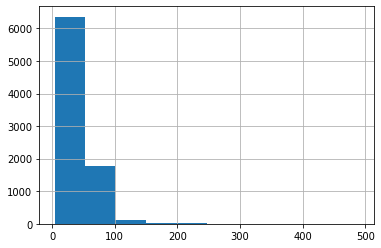

In [16]:
x.hist()

In [17]:
train, test = train_test_split(df, test_size=0.20, random_state=42)

In [18]:
train.shape

(6619, 4)

In [19]:
test.shape

(1655, 4)

In [20]:
#padding length = maxlen
maxlen = 150

In [21]:
xtest, ytest = clean_dataset(test)
Xtest, Ytest = encode_dataset(xtest,ytest)
padded_xTest, padded_yTest = padding_dataset(Xtest,Ytest,maxlen)

In [22]:
padded_xTest.shape

(1655, 150)

In [23]:
#without noise (Experiment 1)
x, y = clean_dataset(train)

In [24]:
len(y)

6619

In [25]:
encode_dict = {l:i+1 for i,l in enumerate(string.ascii_uppercase + " ")}

In [26]:
x_all, y_all = clean_dataset(df)
len(y_all)

8274

In [27]:
Xtrain = [[encode_dict[m] for m in n] for n in x]
Ytrain = [[encode_dict[m] for m in n] for n in y]

In [28]:
print(len(Xtrain))
print(len(Ytrain))
np.unique(Ytrain).shape

6619
6619


/home/sanya/.conda/envs/faers-embed/lib/python3.8/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


(124,)

In [29]:
padded_y = tf.keras.preprocessing.sequence.pad_sequences(
    Ytrain, padding="post", maxlen=maxlen
)
padded_x = tf.keras.preprocessing.sequence.pad_sequences(
    Xtrain, padding="post", maxlen=maxlen
)

print(padded_y)

[[ 1 12 12 ...  0  0  0]
 [12  9 14 ...  0  0  0]
 [15  5 14 ...  0  0  0]
 ...
 [ 3  1 14 ...  0  0  0]
 [ 7  9 14 ...  0  0  0]
 [20 18  9 ...  0  0  0]]


In [30]:
len(encode_dict)

27

In [31]:
dUnique_df = pd.DataFrame(columns = ['dUnique_label','dUnique_seq', 'dUnique_seq_padded'])
dUnique_df['dUnique_label'] = np.unique(y_all)
dUnique_df.head()

,dUnique_label,dUnique_seq,dUnique_seq_padded
0,ACTAEA RACEMOSA,NaN,NaN
1,AESCULUS HIPPOCASTANUM,NaN,NaN
2,ALLIUM SATIVUM,NaN,NaN
3,ALOE VERA,NaN,NaN
4,ANGELICA SINENSIS,NaN,NaN


In [32]:
dUnique_seq_list = [[encode_dict[m] for m in n] for n in dUnique_df['dUnique_label'].tolist()]
len(dUnique_seq_list)

126

In [33]:
for i in range(len(dUnique_df.index)):
    dUnique_df.at[i, 'dUnique_seq'] = np.array(dUnique_seq_list[i])
dUnique_df.head()

,dUnique_label,dUnique_seq,dUnique_seq_padded
0,ACTAEA RACEMOSA,"[1, 3, 20, 1, 5, 1, 27, 18, 1, 3, 5, 13, 15, 1...",NaN
1,AESCULUS HIPPOCASTANUM,"[1, 5, 19, 3, 21, 12, 21, 19, 27, 8, 9, 16, 16...",NaN
2,ALLIUM SATIVUM,"[1, 12, 12, 9, 21, 13, 27, 19, 1, 20, 9, 22, 2...",NaN
3,ALOE VERA,"[1, 12, 15, 5, 27, 22, 5, 18, 1]",NaN
4,ANGELICA SINENSIS,"[1, 14, 7, 5, 12, 9, 3, 1, 27, 19, 9, 14, 5, 1...",NaN


In [34]:
#setup negative pairs - with indications data 
dfneg = pd.read_csv('data/NP_FAERS_mapped_indications_join_on_drugname_negative_20220223.csv')
dfneg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13843 entries, 0 to 13842
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   FAERS_drug_match  13843 non-null  object
 1   lookup_value      13843 non-null  object
 2   indi_pt           8808 non-null   object
dtypes: object(3)
memory usage: 324.6+ KB


In [ ]:
#do same processing for negative pairs with indications


In [35]:
#append indications string to drug name (if not NA)
dfneg['indi_pt'] = dfneg['indi_pt'].fillna('')
dfneg.head()

,FAERS_drug_match,lookup_value,indi_pt
0,"ANUSOL (BENZYL BENZOATE, BISMUTH OXIDE, BISMUT...",Cinnamon,
1,ANUSOL (BENZYL BENZOATE/BISMUTH RESORCINOL/BIS...,Cinnamon,
2,"ANUSOL-HC (BALSAM PERU, BENZYL BENZOATE, BISMU...",Cinnamon,
3,ANUSOL-HC [BENZYL BENZOATE;BISMUTH HYDROXIDE;,Cinnamon,
4,"ANUSOL-HC (BENZYL BENZOATE, BISMUTH HYDROXIDE,...",Cinnamon,


In [36]:
dfneg['FAERS_drug_match_indi'] = dfneg['FAERS_drug_match'] + ' ' + dfneg['indi_pt']

In [38]:
dfneg.head()

,FAERS_drug_match,lookup_value,indi_pt,FAERS_drug_match_indi
0,"ANUSOL (BENZYL BENZOATE, BISMUTH OXIDE, BISMUT...",Cinnamon,,"ANUSOL (BENZYL BENZOATE, BISMUTH OXIDE, BISMUT..."
1,ANUSOL (BENZYL BENZOATE/BISMUTH RESORCINOL/BIS...,Cinnamon,,ANUSOL (BENZYL BENZOATE/BISMUTH RESORCINOL/BIS...
2,"ANUSOL-HC (BALSAM PERU, BENZYL BENZOATE, BISMU...",Cinnamon,,"ANUSOL-HC (BALSAM PERU, BENZYL BENZOATE, BISMU..."
3,ANUSOL-HC [BENZYL BENZOATE;BISMUTH HYDROXIDE;,Cinnamon,,ANUSOL-HC [BENZYL BENZOATE;BISMUTH HYDROXIDE;
4,"ANUSOL-HC (BENZYL BENZOATE, BISMUTH HYDROXIDE,...",Cinnamon,,"ANUSOL-HC (BENZYL BENZOATE, BISMUTH HYDROXIDE,..."


In [40]:
x = dfneg.FAERS_drug_match_indi.str.len()
len(x)

13843

<AxesSubplot:>

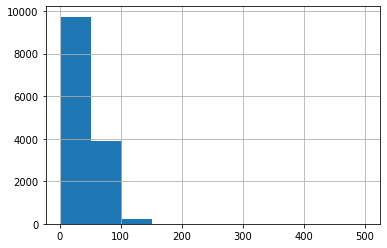

In [41]:
x.hist()

In [42]:
#encode negative pairs and add padding
xneg, yneg = clean_dataset(dfneg)
Xneg, Yneg = encode_dataset(xneg,yneg)
padded_xneg, padded_yneg = padding_dataset(Xneg,Yneg,maxlen)

In [43]:
dUnique = tf.keras.preprocessing.sequence.pad_sequences(
    list(dUnique_df['dUnique_seq']), padding="post", maxlen=maxlen)

In [45]:
train.head()

,FAERS_drug_match,lookup_value,indi_pt,FAERS_drug_match_indi
8118,GARLIC AND PARSLEY GELCAP,ALLIUM SATIVUM,BLOOD PRESSURE ABNORMAL,GARLIC AND PARSLEY GELCAP BLOOD PRESSURE ABNORMAL
4823,NATURES BOUNTY FISH FLAX AND BORAGE,LINUM USITATISSIMUM,,NATURES BOUNTY FISH FLAX AND BORAGE
7999,PRIMROSE OIL CRANBERR,OENOTHERA BIENNIS,,PRIMROSE OIL CRANBERR
5602,HORSE CHESTNUT (FOR BACK),AESCULUS HIPPOCASTANUM,,HORSE CHESTNUT (FOR BACK)
6901,DONGQUAI,ANGELICA SINENSIS,SUPPLEMENTATION THERAPY,DONGQUAI SUPPLEMENTATION THERAPY


In [46]:
np_unique = dUnique_df.dUnique_label.tolist()
len(np_unique)

126

In [47]:
#add positive pairs
x1TrainRNN = []
x2TrainRNN = []
yTrainRNN = []
for i in range(len(padded_x)):
    yTrainRNN.append(1)
    x1TrainRNN.append(padded_x[i])
    x2TrainRNN.append(padded_y[i])
print(len(x1TrainRNN), len(x2TrainRNN), len(yTrainRNN))

6619 6619 6619


In [48]:
train_res = train.reset_index()
train_res.head()

,index,FAERS_drug_match,lookup_value,indi_pt,FAERS_drug_match_indi
0,8118,GARLIC AND PARSLEY GELCAP,ALLIUM SATIVUM,BLOOD PRESSURE ABNORMAL,GARLIC AND PARSLEY GELCAP BLOOD PRESSURE ABNORMAL
1,4823,NATURES BOUNTY FISH FLAX AND BORAGE,LINUM USITATISSIMUM,,NATURES BOUNTY FISH FLAX AND BORAGE
2,7999,PRIMROSE OIL CRANBERR,OENOTHERA BIENNIS,,PRIMROSE OIL CRANBERR
3,5602,HORSE CHESTNUT (FOR BACK),AESCULUS HIPPOCASTANUM,,HORSE CHESTNUT (FOR BACK)
4,6901,DONGQUAI,ANGELICA SINENSIS,SUPPLEMENTATION THERAPY,DONGQUAI SUPPLEMENTATION THERAPY


In [51]:
#take negative pairs from training data
faers_match = []
lookup = []
for i in range(len(train_res)):
    np_name = train_res.at[i, 'FAERS_drug_match_indi']
    for j in random.choices(range(len(np_unique)), k=4):
        np_temp = np_unique[j]
        np_match = train_res.loc[train_res['FAERS_drug_match_indi'] == np_name].lookup_value.tolist()
        if np_temp not in np_match:
            faers_match.append(np_name)
            lookup.append(np_temp)
len(faers_match)

26111

In [52]:
dfneg2 = pd.DataFrame(columns=['FAERS_drug_match_indi', 'lookup_value'])
dfneg2['FAERS_drug_match_indi'] = faers_match
dfneg2['lookup_value'] = lookup
xneg2, yneg2 = clean_dataset(dfneg2)
Xneg2, Yneg2 = encode_dataset(xneg2,yneg2)
padded_xneg2, padded_yneg2 = padding_dataset(Xneg2,Yneg2,maxlen)

In [53]:
##add negative pairs from training data
for j in range(len(padded_xneg2)):
    yTrainRNN.append(0)
    x1TrainRNN.append(padded_xneg2[j])
    x2TrainRNN.append(padded_yneg2[j])
print(len(x1TrainRNN), len(x2TrainRNN), len(yTrainRNN))

32730 32730 32730


In [54]:
##add negative pairs from reference set
for j in range(len(padded_xneg)):
    yTrainRNN.append(0)
    x1TrainRNN.append(padded_xneg[j])
    x2TrainRNN.append(padded_yneg[j])
print(len(x1TrainRNN), len(x2TrainRNN), len(yTrainRNN))

46573 46573 46573


In [55]:
for i in range(len(dUnique_df.index)):
    dUnique_df.at[i, 'dUnique_seq_padded'] = dUnique[i]
dUnique_df.head()

,dUnique_label,dUnique_seq,dUnique_seq_padded
0,ACTAEA RACEMOSA,"[1, 3, 20, 1, 5, 1, 27, 18, 1, 3, 5, 13, 15, 1...","[1, 3, 20, 1, 5, 1, 27, 18, 1, 3, 5, 13, 15, 1..."
1,AESCULUS HIPPOCASTANUM,"[1, 5, 19, 3, 21, 12, 21, 19, 27, 8, 9, 16, 16...","[1, 5, 19, 3, 21, 12, 21, 19, 27, 8, 9, 16, 16..."
2,ALLIUM SATIVUM,"[1, 12, 12, 9, 21, 13, 27, 19, 1, 20, 9, 22, 2...","[1, 12, 12, 9, 21, 13, 27, 19, 1, 20, 9, 22, 2..."
3,ALOE VERA,"[1, 12, 15, 5, 27, 22, 5, 18, 1]","[1, 12, 15, 5, 27, 22, 5, 18, 1, 0, 0, 0, 0, 0..."
4,ANGELICA SINENSIS,"[1, 14, 7, 5, 12, 9, 3, 1, 27, 19, 9, 14, 5, 1...","[1, 14, 7, 5, 12, 9, 3, 1, 27, 19, 9, 14, 5, 1..."


In [56]:
x1TrainRnnS, x2TrainRnnS, yTrainRnnS = shuffle(x1TrainRNN, x2TrainRNN, yTrainRNN, random_state=42)

### build model and train

In [57]:
input = tf.keras.layers.Input(maxlen)
input_1 = tf.keras.layers.Input(maxlen)
input_2 = tf.keras.layers.Input(maxlen)
embedding = tf.keras.layers.Embedding(input_dim=28, output_dim=64, mask_zero=True)
x = embedding(input)

print(x.shape)
x = tf.keras.layers.GRU(128)(x)
x = tf.keras.layers.Dense(64, activation="tanh")(x)
x = tf.keras.layers.Dense(32, activation="tanh")(x)
embedding_network = tf.keras.Model(input, x)

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = tf.keras.layers.Lambda(cosine_distance)([tower_1, tower_2])
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(merge_layer)
siamese = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)

2022-02-23 13:14:13.663017: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-23 13:14:14.592511: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9652 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:af:00.0, compute capability: 7.5


(None, 150, 64)


In [58]:
siamese.compile(loss=loss(margin=1), optimizer='RMSprop', metrics=["accuracy"])

In [59]:
history_rnn = siamese.fit([np.array(x1TrainRnnS), np.array(x2TrainRnnS)],np.array(yTrainRnnS, dtype=np.float32), epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100


2022-02-23 13:14:34.535507: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


1165/1165 [==============================] - 38s 22ms/step - loss: 0.1778 - accuracy: 0.8536 - val_loss: 0.1345 - val_accuracy: 0.8559
Epoch 2/100
1165/1165 [==============================] - 22s 19ms/step - loss: 0.1202 - accuracy: 0.8592 - val_loss: 0.1138 - val_accuracy: 0.8576
Epoch 3/100
1165/1165 [==============================] - 21s 18ms/step - loss: 0.1102 - accuracy: 0.8637 - val_loss: 0.1123 - val_accuracy: 0.8601
Epoch 4/100
1165/1165 [==============================] - 22s 19ms/step - loss: 0.1071 - accuracy: 0.8709 - val_loss: 0.1078 - val_accuracy: 0.8655
Epoch 5/100
1165/1165 [==============================] - 21s 18ms/step - loss: 0.1013 - accuracy: 0.8798 - val_loss: 0.1034 - val_accuracy: 0.8758
Epoch 6/100
1165/1165 [==============================] - 21s 18ms/step - loss: 0.0952 - accuracy: 0.8903 - val_loss: 0.0961 - val_accuracy: 0.8873
Epoch 7/100
1165/1165 [==============================] - 21s 18ms/step - loss: 0.0905 - accuracy: 0.8939 - val_loss: 0.0916 - val_

In [60]:
siamese.save('models/NP_siamese_exp3_20220223.h5')
siamese.save('models/NP_siamese_exp3_20220223')

2022-02-23 13:52:33.058620: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/NP_siamese_exp2_20220223/assets


INFO:tensorflow:Assets written to: models/NP_siamese_exp2_20220223/assets


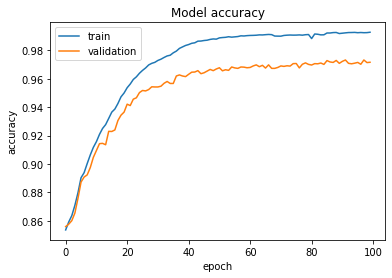

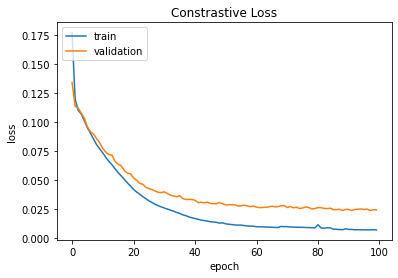

In [61]:
# Plot the accuracy
plt_metric(history=history_rnn.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history_rnn.history, metric="loss", title="Constrastive Loss")

### Load model, get predictions and evaluate siamese network

In [62]:
def contrastive_loss(y_true, y_pred):
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square
    )

In [63]:
#siamese_loaded = tf.keras.models.load_model('models/drug_siamese_exp1_20220201.h5')
siamese_model = tf.keras.models.load_model('models/NP_siamese_exp3_20220223', custom_objects={'contrastive_loss': contrastive_loss})

2022-02-23 13:53:52.745419: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-02-23 13:53:52.950491: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-02-23 13:53:53.846783: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-02-23 13:53:54.184625: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-02-23 13:53:54.230245: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _ou

In [64]:
siamese_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 model (Functional)             (None, 32)           86624       ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

In [65]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1655 entries, 586 to 2884
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   FAERS_drug_match       1655 non-null   object
 1   lookup_value           1655 non-null   object
 2   indi_pt                1655 non-null   object
 3   FAERS_drug_match_indi  1655 non-null   object
dtypes: object(4)
memory usage: 64.6+ KB


In [66]:
test_eval = pd.DataFrame(columns = ['FAERS_drug_match_indi', 'lookup_value', 'rank1_drug', 'rank2_drug', 'rank3_drug', 'rank4_drug', 'rank5_drug', 'lookup_rank'])

In [67]:
test_res = test.reset_index()
test_res.head()

,index,FAERS_drug_match,lookup_value,indi_pt,FAERS_drug_match_indi
0,586,FLAXSEED OIL [LINUM USITATISSIMUM OIL],FLAX SEED,PROPHYLAXIS,FLAXSEED OIL [LINUM USITATISSIMUM OIL] PROPHYL...
1,7013,CHORDYCEPS,OPHIOCORDYCEPS SINENSIS,,CHORDYCEPS
2,7716,CRANBERRY PLUS [JUNIPERUS COMMUNIS;VACCINIUM M...,VACCINIUM MACROCARPON,PRODUCT USED FOR UNKNOWN INDICATION,CRANBERRY PLUS [JUNIPERUS COMMUNIS;VACCINIUM M...
3,970,GREEN TEA 150MG,GREEN TEA,,GREEN TEA 150MG
4,8173,ODOR FREE GARLIC?X,ALLIUM SATIVUM,,ODOR FREE GARLIC?X


In [68]:
#find ranks 1, 2 and 3 (can go upto any number n) from the predicted similarities for the test data
for i in range(padded_xTest.shape[0]):
    predicts = siamese.predict([np.tile(padded_xTest[i,:], (dUnique.shape[0],1)), dUnique])
    argsort = np.argsort(-predicts.flatten())
    test_eval.at[i, 'FAERS_drug_match_indi'] = test_res.at[i, 'FAERS_drug_match_indi']
    test_eval.at[i, 'lookup_value'] = test_res.at[i, 'lookup_value']
    test_eval.at[i, 'rank1_drug'] = dUnique_df.iloc[argsort[0]].dUnique_label
    test_eval.at[i, 'rank2_drug'] = dUnique_df.iloc[argsort[1]].dUnique_label
    test_eval.at[i, 'rank3_drug'] = dUnique_df.iloc[argsort[2]].dUnique_label
    test_eval.at[i, 'rank4_drug'] = dUnique_df.iloc[argsort[3]].dUnique_label
    test_eval.at[i, 'rank5_drug'] = dUnique_df.iloc[argsort[4]].dUnique_label
test_eval.head()

,FAERS_drug_match_indi,lookup_value,rank1_drug,rank2_drug,rank3_drug,rank4_drug,rank5_drug,lookup_rank
0,FLAXSEED OIL [LINUM USITATISSIMUM OIL] PROPHYL...,FLAX SEED,LINUM USITATISSIMUM,FLAX SEED,CANNABIS SATIVA,HEMP EXTRACT,CINNAMON,NaN
1,CHORDYCEPS,OPHIOCORDYCEPS SINENSIS,FENUGREEK,TRIGONELFA FOENUM,WITHANIA SOMNIFERA,ASHWAGANDA,SERENOA REPENS,NaN
2,CRANBERRY PLUS [JUNIPERUS COMMUNIS;VACCINIUM M...,VACCINIUM MACROCARPON,VACCINIUM MACROCARPON,CRANBERRY,WOOD SPIDER,RHODIOLA,RHODIOLA ROSEA,NaN
3,GREEN TEA 150MG,GREEN TEA,CAMELLIA SINENSIS,GREEN TEA,RED YEAST RICE,CINNAMOMUM VERUM,ORYZA SATIVA,NaN
4,ODOR FREE GARLIC?X,ALLIUM SATIVUM,GARLIC,ALLIUM SATIVUM,MITRAGYNA SPECIOSA,PAULLINIA CUPANA,CANNABIS SATIVA,NaN


In [69]:
for i in range(len(test_eval.index)):
    lookup = test_eval.at[i, 'lookup_value']
    lookup_clean = clean(lookup)
    if lookup_clean == test_eval.at[i, 'rank1_drug']:
        test_eval.at[i, 'lookup_rank'] = 1
    elif lookup_clean == test_eval.at[i, 'rank2_drug']:
        test_eval.at[i, 'lookup_rank'] = 2
    elif lookup_clean == test_eval.at[i, 'rank3_drug']:
        test_eval.at[i, 'lookup_rank'] = 3
    elif lookup_clean == test_eval.at[i, 'rank4_drug']:
        test_eval.at[i, 'lookup_rank'] = 4
    elif lookup_clean == test_eval.at[i, 'rank5_drug']:
        test_eval.at[i, 'lookup_rank'] = 5
test_eval.head()

,FAERS_drug_match_indi,lookup_value,rank1_drug,rank2_drug,rank3_drug,rank4_drug,rank5_drug,lookup_rank
0,FLAXSEED OIL [LINUM USITATISSIMUM OIL] PROPHYL...,FLAX SEED,LINUM USITATISSIMUM,FLAX SEED,CANNABIS SATIVA,HEMP EXTRACT,CINNAMON,2
1,CHORDYCEPS,OPHIOCORDYCEPS SINENSIS,FENUGREEK,TRIGONELFA FOENUM,WITHANIA SOMNIFERA,ASHWAGANDA,SERENOA REPENS,NaN
2,CRANBERRY PLUS [JUNIPERUS COMMUNIS;VACCINIUM M...,VACCINIUM MACROCARPON,VACCINIUM MACROCARPON,CRANBERRY,WOOD SPIDER,RHODIOLA,RHODIOLA ROSEA,1
3,GREEN TEA 150MG,GREEN TEA,CAMELLIA SINENSIS,GREEN TEA,RED YEAST RICE,CINNAMOMUM VERUM,ORYZA SATIVA,2
4,ODOR FREE GARLIC?X,ALLIUM SATIVUM,GARLIC,ALLIUM SATIVUM,MITRAGYNA SPECIOSA,PAULLINIA CUPANA,CANNABIS SATIVA,2


In [70]:
test_eval.to_csv("evaluation/test_siamese_evaluation_exp3.csv", index=False)

In [71]:
##add related mappings rank to test set evaluation

In [72]:
vocab = pd.read_csv('data/lb_to_common_names.csv')
vocab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   latin_binomial        958 non-null    object
 1   common_name           958 non-null    object
 2   latin_binomial_clean  958 non-null    object
 3   common_name_clean     958 non-null    object
dtypes: object(4)
memory usage: 30.1+ KB


In [73]:
test_eval = pd.read_csv('evaluation/test_siamese_evaluation_exp3.csv')
test_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1655 entries, 0 to 1654
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FAERS_drug_match_indi  1655 non-null   object 
 1   lookup_value           1655 non-null   object 
 2   rank1_drug             1655 non-null   object 
 3   rank2_drug             1655 non-null   object 
 4   rank3_drug             1655 non-null   object 
 5   rank4_drug             1655 non-null   object 
 6   rank5_drug             1655 non-null   object 
 7   lookup_rank            1463 non-null   float64
dtypes: float64(1), object(7)
memory usage: 103.6+ KB


In [74]:
test_eval['lookup_rank_related'] = np.nan
test_eval.head()

,FAERS_drug_match_indi,lookup_value,rank1_drug,rank2_drug,rank3_drug,rank4_drug,rank5_drug,lookup_rank,lookup_rank_related
0,FLAXSEED OIL [LINUM USITATISSIMUM OIL] PROPHYL...,FLAX SEED,LINUM USITATISSIMUM,FLAX SEED,CANNABIS SATIVA,HEMP EXTRACT,CINNAMON,2.0,NaN
1,CHORDYCEPS,OPHIOCORDYCEPS SINENSIS,FENUGREEK,TRIGONELFA FOENUM,WITHANIA SOMNIFERA,ASHWAGANDA,SERENOA REPENS,NaN,NaN
2,CRANBERRY PLUS [JUNIPERUS COMMUNIS;VACCINIUM M...,VACCINIUM MACROCARPON,VACCINIUM MACROCARPON,CRANBERRY,WOOD SPIDER,RHODIOLA,RHODIOLA ROSEA,1.0,NaN
3,GREEN TEA 150MG,GREEN TEA,CAMELLIA SINENSIS,GREEN TEA,RED YEAST RICE,CINNAMOMUM VERUM,ORYZA SATIVA,2.0,NaN
4,ODOR FREE GARLIC?X,ALLIUM SATIVUM,GARLIC,ALLIUM SATIVUM,MITRAGYNA SPECIOSA,PAULLINIA CUPANA,CANNABIS SATIVA,2.0,NaN


In [75]:
#find related mappings to lookup value in predicted values 
for i in range(len(test_eval.index)):
    lookup = test_eval.at[i, 'lookup_value']
    lookup_rank = test_eval.at[i, 'lookup_rank']
    lookup_clean = clean(lookup)
    lb_res = vocab.loc[vocab['latin_binomial_clean'] == lookup_clean]
    common_res = vocab.loc[vocab['common_name_clean'] == lookup_clean]
    lookup_result = ''
    if len(lb_res) > 0:
        lookup_result = lb_res.common_name_clean.values[0]
    elif len(common_res) > 0:
        lookup_result = common_res.latin_binomial_clean.values[0]
    if lookup_result != '':
        if lookup_result == test_eval.at[i, 'rank1_drug']:
            test_eval.at[i, 'lookup_rank_related'] = 1
        elif lookup_result == test_eval.at[i, 'rank2_drug']:
            if lookup_rank:
                if lookup_rank > 2:
                    test_eval.at[i, 'lookup_rank_related'] = 2
                else:
                    test_eval.at[i, 'lookup_rank_related'] = lookup_rank
            elif np.isnan(lookup_rank):
                test_eval.at[i, 'lookup_rank_related'] = 2
        elif lookup_result == test_eval.at[i, 'rank3_drug']:
            if lookup_rank:
                if lookup_rank > 3:
                    test_eval.at[i, 'lookup_rank_related'] = 3
                else:
                    test_eval.at[i, 'lookup_rank_related'] = lookup_rank
            elif np.isnan(lookup_rank):
                test_eval.at[i, 'lookup_rank_related'] = 3
        elif lookup_result == test_eval.at[i, 'rank4_drug']:
            if lookup_rank:
                if lookup_rank > 4:
                    test_eval.at[i, 'lookup_rank_related'] = 4
                else:
                    test_eval.at[i, 'lookup_rank_related'] = lookup_rank
            elif np.isnan(lookup_rank):
                test_eval.at[i, 'lookup_rank_related'] = 4
        elif lookup_result == test_eval.at[i, 'rank5_drug']:
            if np.isnan(lookup_rank):
                test_eval.at[i, 'lookup_rank_related'] = 5
        
test_eval.head()

,FAERS_drug_match_indi,lookup_value,rank1_drug,rank2_drug,rank3_drug,rank4_drug,rank5_drug,lookup_rank,lookup_rank_related
0,FLAXSEED OIL [LINUM USITATISSIMUM OIL] PROPHYL...,FLAX SEED,LINUM USITATISSIMUM,FLAX SEED,CANNABIS SATIVA,HEMP EXTRACT,CINNAMON,2.0,1.0
1,CHORDYCEPS,OPHIOCORDYCEPS SINENSIS,FENUGREEK,TRIGONELFA FOENUM,WITHANIA SOMNIFERA,ASHWAGANDA,SERENOA REPENS,NaN,NaN
2,CRANBERRY PLUS [JUNIPERUS COMMUNIS;VACCINIUM M...,VACCINIUM MACROCARPON,VACCINIUM MACROCARPON,CRANBERRY,WOOD SPIDER,RHODIOLA,RHODIOLA ROSEA,1.0,1.0
3,GREEN TEA 150MG,GREEN TEA,CAMELLIA SINENSIS,GREEN TEA,RED YEAST RICE,CINNAMOMUM VERUM,ORYZA SATIVA,2.0,1.0
4,ODOR FREE GARLIC?X,ALLIUM SATIVUM,GARLIC,ALLIUM SATIVUM,MITRAGYNA SPECIOSA,PAULLINIA CUPANA,CANNABIS SATIVA,2.0,1.0


In [76]:
#post process to make lookup rank = lookup rank related if related is nan still
for i in range(len(test_eval.index)):
    lookup_rank = test_eval.at[i, 'lookup_rank']
    lookup_rank_related = test_eval.at[i, 'lookup_rank_related']
    if lookup_rank:
        if np.isnan(lookup_rank_related):
            test_eval.at[i, 'lookup_rank_related'] = lookup_rank
test_eval.head()

,FAERS_drug_match_indi,lookup_value,rank1_drug,rank2_drug,rank3_drug,rank4_drug,rank5_drug,lookup_rank,lookup_rank_related
0,FLAXSEED OIL [LINUM USITATISSIMUM OIL] PROPHYL...,FLAX SEED,LINUM USITATISSIMUM,FLAX SEED,CANNABIS SATIVA,HEMP EXTRACT,CINNAMON,2.0,1.0
1,CHORDYCEPS,OPHIOCORDYCEPS SINENSIS,FENUGREEK,TRIGONELFA FOENUM,WITHANIA SOMNIFERA,ASHWAGANDA,SERENOA REPENS,NaN,NaN
2,CRANBERRY PLUS [JUNIPERUS COMMUNIS;VACCINIUM M...,VACCINIUM MACROCARPON,VACCINIUM MACROCARPON,CRANBERRY,WOOD SPIDER,RHODIOLA,RHODIOLA ROSEA,1.0,1.0
3,GREEN TEA 150MG,GREEN TEA,CAMELLIA SINENSIS,GREEN TEA,RED YEAST RICE,CINNAMOMUM VERUM,ORYZA SATIVA,2.0,1.0
4,ODOR FREE GARLIC?X,ALLIUM SATIVUM,GARLIC,ALLIUM SATIVUM,MITRAGYNA SPECIOSA,PAULLINIA CUPANA,CANNABIS SATIVA,2.0,1.0


In [77]:
test_eval.to_csv('evaluation/test_siamese_evaluation_related_exp3.csv', index=False)

In [78]:
###compute MRR from test set evaluation

In [80]:
test_mrr = test_eval[['FAERS_drug_match_indi', 'lookup_rank', 'lookup_rank_related']]
test_mrr.head()

,FAERS_drug_match_indi,lookup_rank,lookup_rank_related
0,FLAXSEED OIL [LINUM USITATISSIMUM OIL] PROPHYL...,2.0,1.0
1,CHORDYCEPS,NaN,NaN
2,CRANBERRY PLUS [JUNIPERUS COMMUNIS;VACCINIUM M...,1.0,1.0
3,GREEN TEA 150MG,2.0,1.0
4,ODOR FREE GARLIC?X,2.0,1.0


In [81]:
test_mrr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1655 entries, 0 to 1654
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FAERS_drug_match_indi  1655 non-null   object 
 1   lookup_rank            1463 non-null   float64
 2   lookup_rank_related    1470 non-null   float64
dtypes: float64(2), object(1)
memory usage: 38.9+ KB


In [82]:
#number of 0 relevant results
test_mrr.loc[test_mrr['lookup_rank'].isna()].shape

(192, 3)

In [83]:
test_mrr.loc[test_mrr['lookup_rank_related'].isna()].shape

(185, 3)

In [84]:
test_mrr_exact = test_mrr[test_mrr['lookup_rank'].notna()]
test_mrr_exact = test_mrr_exact.drop(['lookup_rank_related'], axis=1)
test_mrr_exact.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 0 to 1654
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FAERS_drug_match_indi  1463 non-null   object 
 1   lookup_rank            1463 non-null   float64
dtypes: float64(1), object(1)
memory usage: 34.3+ KB


In [85]:
test_mrr_rel = test_mrr[test_mrr['lookup_rank_related'].notna()]
test_mrr_rel = test_mrr_rel.drop(['lookup_rank'], axis=1)
test_mrr_rel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470 entries, 0 to 1654
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FAERS_drug_match_indi  1470 non-null   object 
 1   lookup_rank_related    1470 non-null   float64
dtypes: float64(1), object(1)
memory usage: 34.5+ KB


In [86]:
exact_reciprocal = 1/test_mrr_exact['lookup_rank']
test_mrr_exact['reciprocal_rank'] = exact_reciprocal
test_mrr_exact.head()

,FAERS_drug_match_indi,lookup_rank,reciprocal_rank
0,FLAXSEED OIL [LINUM USITATISSIMUM OIL] PROPHYL...,2.0,0.5
2,CRANBERRY PLUS [JUNIPERUS COMMUNIS;VACCINIUM M...,1.0,1.0
3,GREEN TEA 150MG,2.0,0.5
4,ODOR FREE GARLIC?X,2.0,0.5
5,GREEN TEA (PLANT ALKALOIDS AND OTHER NATURAL R...,2.0,0.5


In [87]:
##get the mean of reciprocal ranks for exact matches
test_mrr_exact.reciprocal_rank.mean()

0.7198678514467987

In [88]:
rel_reciprocal = 1/test_mrr_rel['lookup_rank_related']
test_mrr_rel['reciprocal_rank'] = rel_reciprocal
test_mrr_rel.head()

,FAERS_drug_match_indi,lookup_rank_related,reciprocal_rank
0,FLAXSEED OIL [LINUM USITATISSIMUM OIL] PROPHYL...,1.0,1.0
2,CRANBERRY PLUS [JUNIPERUS COMMUNIS;VACCINIUM M...,1.0,1.0
3,GREEN TEA 150MG,1.0,1.0
4,ODOR FREE GARLIC?X,1.0,1.0
5,GREEN TEA (PLANT ALKALOIDS AND OTHER NATURAL R...,2.0,0.5


In [89]:
test_mrr_rel.reciprocal_rank.mean()

0.9029251700680272

### Scratch code blocks below

In [43]:
siamese_model.layers[0]

In [74]:
##try to get embedding weights - this gives from original model not trained (I think)
embeddings_weights = embedding.get_weights()[0]

In [48]:
for layer in siamese_model.layers:
    print(layer)

In [37]:
#in test set, find all NPs and create NP-test
npref = pd.read_csv('data/np_faers_reference_set_202202101209.csv')
npref.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2679 entries, 0 to 2678
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   seq                     2679 non-null   int64  
 1   drug_name_original      2679 non-null   object 
 2   related_common_name     2679 non-null   object 
 3   related_latin_binomial  2679 non-null   object 
 4   lookup_value            2679 non-null   object 
 5   concept_id              1925 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 125.7+ KB


In [50]:
testnp = test.reset_index()
testnp.head()

,index,drug_name_original,lookup_value
0,368981,NITROGLYCERIN PILLS,NITROGLYCERIN
1,20960,VITAMINS/MINERALS D3 B50 COMPLEX,MULTIVITAMIN PREPARATION
2,320735,T. SELOKEN ZOC (METOPROLOL SUCCINATE),METOPROLOL SUCCINATE
3,34002,CEFTUM TABLET,CEFUROXIME AXETIL
4,321068,VALPROATE (TABLETS) VALPROATE SODIUM,VALPROATE SODIUM


In [39]:
testnp_df = pd.merge(testnp, npref, how='inner', on=['drug_name_original'])
testnp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 483 entries, 0 to 482
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   483 non-null    int64  
 1   drug_name_original      483 non-null    object 
 2   lookup_value_x          483 non-null    object 
 3   seq                     483 non-null    int64  
 4   related_common_name     483 non-null    object 
 5   related_latin_binomial  483 non-null    object 
 6   lookup_value_y          483 non-null    object 
 7   concept_id              340 non-null    float64
dtypes: float64(1), int64(2), object(5)
memory usage: 34.0+ KB


In [41]:
testnp_df = testnp_df[['index', 'drug_name_original', 'lookup_value_x']]
testnp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 483 entries, 0 to 482
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   index               483 non-null    int64 
 1   drug_name_original  483 non-null    object
 2   lookup_value_x      483 non-null    object
dtypes: int64(1), object(2)
memory usage: 15.1+ KB


In [43]:
testnp_df = testnp_df.rename(columns={"lookup_value_x": "lookup_value"})

In [44]:
testnp_df.to_csv('evaluation/test_set_np.csv', index=False)

In [45]:
test_np_eval = pd.DataFrame(columns = ['drug_name_original', 'lookup_value', 'rank1_drug', 'rank2_drug', 'rank3_drug', 'lookup_rank'])

In [46]:
testnp_df.head()

,index,drug_name_original,lookup_value
0,106183,CRANBERRY CHEWS,CRANBERRY
1,106466,BARLEY GREEN,BARLEY GRASS
2,107020,CRANBERRY [VACCINIUM MACROCARPON,CRANBERRY
3,322801,GREEN TEA OTC,GREEN TEA
4,106189,FLAX CAPSULES,FLAX SEED


In [51]:
npxtest, npytest = clean_dataset(testnp_df)
npXtest, npYtest = encode_dataset(npxtest,npytest)
nppadded_xTest, nppadded_yTest = padding_dataset(npXtest,npYtest)

In [54]:
#testing model on only NPs in test set
for i in range(len(testnp_df.index)):
    np_index = testnp_df.at[i, 'index']
    predicts = siamese_model.predict([np.tile(nppadded_xTest[i,:], (dUnique.shape[0],1)), dUnique])
    argsort = np.argsort(-predicts.flatten())
    test_np_eval.at[i, 'drug_name_original'] = test.at[np_index, 'drug_name_original']
    test_np_eval.at[i, 'lookup_value'] = test.at[np_index, 'lookup_value']
    test_np_eval.at[i, 'rank1_drug'] = dUnique_df.iloc[argsort[0]].dUnique_label
    test_np_eval.at[i, 'rank2_drug'] = dUnique_df.iloc[argsort[1]].dUnique_label
    test_np_eval.at[i, 'rank3_drug'] = dUnique_df.iloc[argsort[2]].dUnique_label
test_np_eval.head()

2022-02-10 12:39:08.325967: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


,drug_name_original,lookup_value,rank1_drug,rank2_drug,rank3_drug,lookup_rank
0,CRANBERRY CHEWS,CRANBERRY,CRANBERRY JUICE,CRANBERRY PREPARATION,CRANBERRY,NaN
1,BARLEY GREEN,BARLEY GRASS,BARLEY GRASS,BARBITAL,BARBEXACLONE,NaN
2,CRANBERRY [VACCINIUM MACROCARPON,CRANBERRY,CANRENOATE POTASSIUM,CRANTEX LA,CRANBERRY EXTRACT,NaN
3,GREEN TEA OTC,GREEN TEA,GREEN TEA EXTRACT,GREEN TEA,GREEN TEA LEAF EXTRACT,NaN
4,FLAX CAPSULES,FLAX SEED,FLURESS,FLUOROURACIL,FLUANXOL,NaN


In [55]:
for i in range(len(test_np_eval.index)):
    lookup = test_np_eval.at[i, 'lookup_value']
    if lookup == test_np_eval.at[i, 'rank1_drug']:
        test_np_eval.at[i, 'lookup_rank'] = 1
    elif lookup == test_np_eval.at[i, 'rank2_drug']:
        test_np_eval.at[i, 'lookup_rank'] = 2
    elif lookup == test_np_eval.at[i, 'rank3_drug']:
        test_np_eval.at[i, 'lookup_rank'] = 3
test_np_eval.head()


,drug_name_original,lookup_value,rank1_drug,rank2_drug,rank3_drug,lookup_rank
0,CRANBERRY CHEWS,CRANBERRY,CRANBERRY JUICE,CRANBERRY PREPARATION,CRANBERRY,3
1,BARLEY GREEN,BARLEY GRASS,BARLEY GRASS,BARBITAL,BARBEXACLONE,1
2,CRANBERRY [VACCINIUM MACROCARPON,CRANBERRY,CANRENOATE POTASSIUM,CRANTEX LA,CRANBERRY EXTRACT,NaN
3,GREEN TEA OTC,GREEN TEA,GREEN TEA EXTRACT,GREEN TEA,GREEN TEA LEAF EXTRACT,2
4,FLAX CAPSULES,FLAX SEED,FLURESS,FLUOROURACIL,FLUANXOL,NaN


In [56]:
test_np_eval.to_csv('evaluation/siamese_eval_NP_exp1.csv', index=False)

# Comparison between methods
- use hit@topK metrics 

In [ ]:
def hit_at_k(predictions):
  
    N = len(predictions)
    hitAt = []
    predictions = np.array(predictions)
    predictions.sort()
    
    for k in range(N):
      atK = (predictions <= k).sum()
      hitAt.append(atK/N)

    return hitAt

In [ ]:
se = hit_at_k(ranksEmbed)
mp = hit_at_k(all_f[0])
nm = hit_at_k(all_f2[0])
sn = hit_at_k(siamese_ranks)

In [ ]:
se10 = [hit_at_k(r) for r in ranks10]
mp10 = [hit_at_k(r) for r in ranks10_mp_0]
nm10 = [hit_at_k(r) for r in ranks10_nm_0]

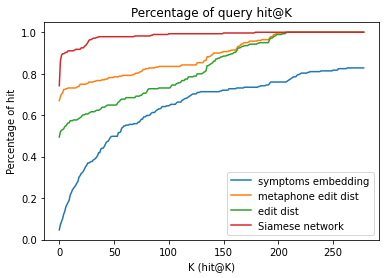

In [ ]:
plt.plot(range(len(se)), se, label="symptoms embedding")
plt.plot(range(len(se)), mp, label="metaphone edit dist")
plt.plot(range(len(se)), nm, label="edit dist")
plt.plot(range(len(se)), sn, label="Siamese network")
plt.legend()
plt.xlabel("K (hit@K)")
plt.ylabel("Percentage of hit")
plt.title("Percentage of query hit@K")
plt.show()

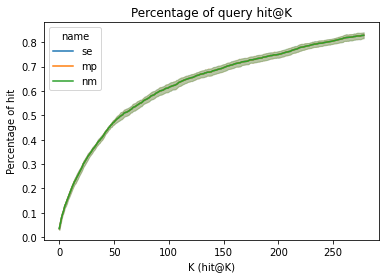

In [ ]:
# I need to repeat this. Last time I use wrong variables. -*- 

dt1 = pd.DataFrame(se10)
dt1 = pd.melt(dt1.reset_index(), id_vars="index")
dt1["name"] = "se"
dt2 = pd.DataFrame(mp10)
dt2 = pd.melt(dt2.reset_index(), id_vars="index")
dt2["name"] ="mp"
dt3 = pd.DataFrame(nm10)
dt3 = pd.melt(dt3.reset_index(), id_vars="index")
dt3["name"] = "nm"
dt =pd.concat([dt1,dt2,dt3])

sns.lineplot( x = "variable", y = "value", hue="name", data=dt.reset_index(drop=True))
plt.xlabel("K (hit@K)")
plt.ylabel("Percentage of hit")
plt.title("Percentage of query hit@K")
plt.show()